# AI Exam

Consider the following environment:

<img src="images/road_env.jpg" style="zoom: 40%;"/>

The agent starts in cell $(0, 0)$ and must reach the goal in cell $(8,6)$. The agent can move in the four directions (except when a wall is present), and for each step taken the agent receives a negative reward.
In cells representing roads with intersections, the agent must wait for the traffic light to turn green before proceeding. At busy intersections (indicated by two traffic lights in the same cell), the agent will have to wait a long time to cross the intersection. This means that if the agent tries to move to another cell, the action may not succeed, causing the agent to remain in the same cell for an unknown amount of time.

Assume that you do not have access to the motion model and to reward and that the problem is undiscounted, find a solution for the environment reported above with a suitable algorithm of your choice, motivating your choice.

In [1]:
import os, sys 

module_path = os.path.abspath(os.path.join('tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
import numpy as np
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

env_name = 'RoadEnv-v0'
env = gym.make(env_name)

env.render()

print("\nActions encoding: ", env.actions)

# Remember that you can know the type of a cell whenever you need by accessing the grid element of the environment:
print("Cell type of start state: ",env.grid[env.startstate])
print("Cell type of goal state: ",env.grid[env.goalstate])
state = 15 # a very busy intersection
print(f"Cell type of cell {env.state_to_pos(state)}: ",env.grid[state])
state = 10 # a less busy intersection
print(f"Cell type of cell {env.state_to_pos(state)}: ",env.grid[state])

# stampo delle informazioni agiuntive
print("\nReward of starting state:", env.RS[env.startstate])
print("Reward of goal state:", env.RS[env.goalstate])

print("\nSINGLE traffic light:")
current_state = env.pos_to_state(1, 1)
next_state = env.pos_to_state(2, 1)
print("Probability from (1, 1) to (2, 1) with action down: ", env.T[current_state, 3, next_state]) # probabilità di andare giù in caso di SINGOLO semaforo
print("Probability from (1, 1) to stay in (1, 1) with action down: ", env.T[current_state, 3, current_state]) # probabilità di andare su in caso di SINGOLO semaforo

print("\nDOUBLE traffic light:")
current_state = env.pos_to_state(1, 6)
next_state = env.pos_to_state(2, 6)
print("Probability from (1, 6) to (2, 6) with action down: ", env.T[current_state, 3, next_state]) # probabilità di andare giù in caso di DOPPIO semaforo
print("Probability from (1, 6) to stay in (1, 6) with action down: ", env.T[current_state, 3, current_state]) # probabilità di andare su in caso di DOPPIO semaforo


[['S' 'R' 'W' 'W' 'W' 'W' 'R' 'W' 'W']
 ['W' 'Ts' 'R' 'R' 'R' 'R' 'Tl' 'R' 'R']
 ['W' 'R' 'W' 'W' 'W' 'W' 'R' 'W' 'W']
 ['R' 'Ts' 'R' 'Ts' 'R' 'R' 'Ts' 'W' 'W']
 ['W' 'W' 'W' 'R' 'W' 'W' 'R' 'Ts' 'R']
 ['W' 'R' 'R' 'Tl' 'W' 'W' 'W' 'R' 'W']
 ['W' 'R' 'W' 'R' 'Ts' 'R' 'R' 'Tl' 'R']
 ['W' 'R' 'W' 'W' 'R' 'W' 'W' 'R' 'W']
 ['R' 'Ts' 'R' 'R' 'Tl' 'R' 'G' 'Ts' 'R']]

Actions encoding:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}
Cell type of start state:  S
Cell type of goal state:  G
Cell type of cell (1, 6):  Tl
Cell type of cell (1, 1):  Ts

Reward of starting state: -0.04
Reward of goal state: 5.0

SINGLE traffic light:
Probability from (1, 1) to (2, 1) with action down:  0.8
Probability from (1, 1) to stay in (1, 1) with action down:  0.2

DOUBLE traffic light:
Probability from (1, 6) to (2, 6) with action down:  0.2
Probability from (1, 6) to stay in (1, 6) with action down:  0.8



Implementation of **epsilon-greedy** and **softmax** functions to guide decisions in the algorithm of choice (*Q-learning*).

We chose to use *ML* algorithms because the agent doesn't have access to the probability of reaching a certain state by executing an action. This means it's not an *MDP* problem, so the machine needs to be able to calculate the policies by itself, without the discount variable.

In [2]:
def epsilon_greedy(q, state, epsilon):

    if np.random.random() < epsilon: #enters the if only if the random number is less than epsilon (i.e., with probability  epsilon)
        return np.random.choice(q.shape[1]) #the size of first dimension of q is number of states, the second is number of actions 
    return q[state].argmax() #q[state] is a vector of q-values indexed by actions

def softmax(q, state, temp):
    e = np.exp(q[state] / temp) #a vector indexed by action where each value is e^(q(s,a)/T)
    return np.random.choice(q.shape[1], p=e / e.sum()) # choose an action with probability e^(q(s,a)/T)/sum_{a'} e^(q(s,a')/T)  

Implementation of the **Q-Learning algorithm**, as seen in the lab sessions.

In [3]:
def q_learning(environment, episodes, alpha, gamma, expl_func, expl_param):
    
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)

    for i in range(episodes):
        # resetto l'ambiente alla posizione iniziale (stato iniziale)
        state = environment.reset()
        stop = False 

        while(not stop):
            action = expl_func(q, state, expl_param)
            
            next_state, reward, done, _ = environment.step(action)

            q[state][action] = q[state][action] + alpha * (reward + gamma*max(q[next_state, :]) - q[state][action])

            state = next_state

            # aggiorno il conteggio dei reward e la lunghezza dell'episodio
            rews[i] += reward
            lengths[i] += 1
            stop = done
              
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths # mi serve solo la policy come output

Implementation of the **SARSA** algorithm (*unused*)

In [4]:
def sarsa(environment, episodes, alpha, gamma, expl_func, expl_param):
    q = np.zeros((environment.observation_space.n, environment.action_space.n))  # Q(s, a)
    rews = np.zeros(episodes)
    lengths = np.zeros(episodes)

    for i in range(episodes):
        # resetto l'ambiente alla posizione iniziale (stato iniziale)
        state = environment.reset()
        action = expl_func(q, state, expl_param)
        stop = False 

        while(not stop):
            next_state, reward, stop, _ = environment.step(action)
            next_action = expl_func(q, next_state, expl_param)

            q[state][action] = q[state][action] + alpha * (reward + gamma*q[next_state, next_action] - q[state][action])

            state = next_state
            action = next_action

            # aggiorno il conteggio dei reward e la lunghezza dell'episodio
            rews[i] += reward
            lengths[i] += 1
              
    policy = q.argmax(axis=1) # q.argmax(axis=1) automatically extract the policy from the q table
    return policy, rews, lengths

In [5]:
#IMPLEMENT THIS FUNCTION, YOU CAN CHANGE THE PARAMETERS FOR THE FUNCTION IF THIS IS USEFUL
def my_solution(environment): 
    
    episodes = 1000 # th higher the number of episodes, the more accurate the solution will be
    alpha = .3
    gamma = .9
    epsilon = .1

    # calling the Q-Learning algorithm function
    policy, _, _ = q_learning(environment, episodes, alpha, gamma, softmax, epsilon)
    
    return policy

    # return np.random.choice(environment.action_space.n,environment.observation_space.n)

### CHOICE:
Between **Q-Learning** and **SARSA** we chose the former, since we don't need to worry about finding a "safe" route since there are no end of episode states with heavy negative rewards. Because of this, Q-Learning is more efficient in finding the optimal path only based on rewards and not safety (just like in the Cliff environment we've seen in the exercises)

<span style="color:red"> **NOTE:** </span>by having a high number of episodes it's possible to obtain the same path found with **value-iteration** *[MDP]* 


#### VISUALIZING RESULTS WITH Q-LEARNING

Execution time: 2.0964s


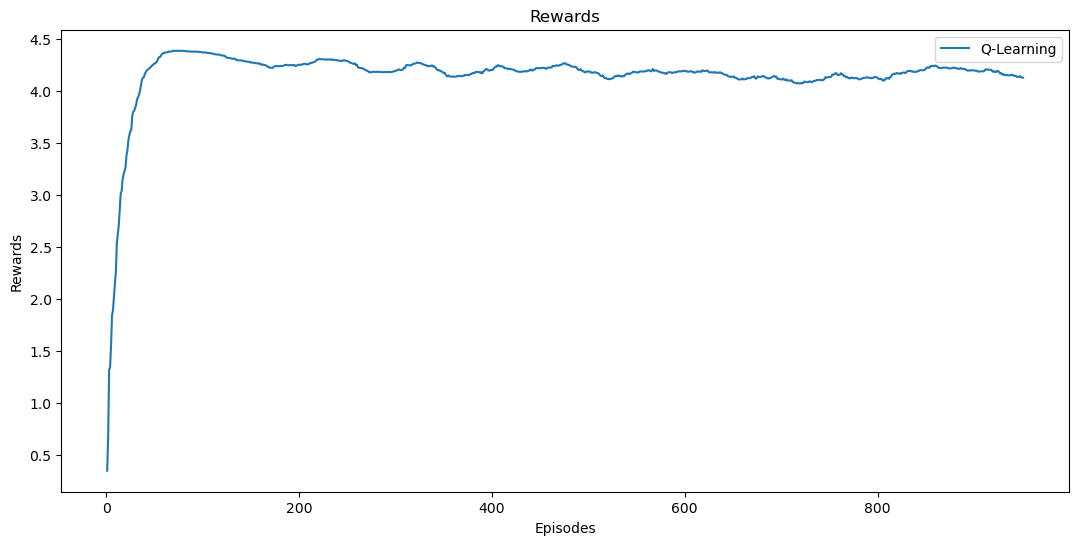

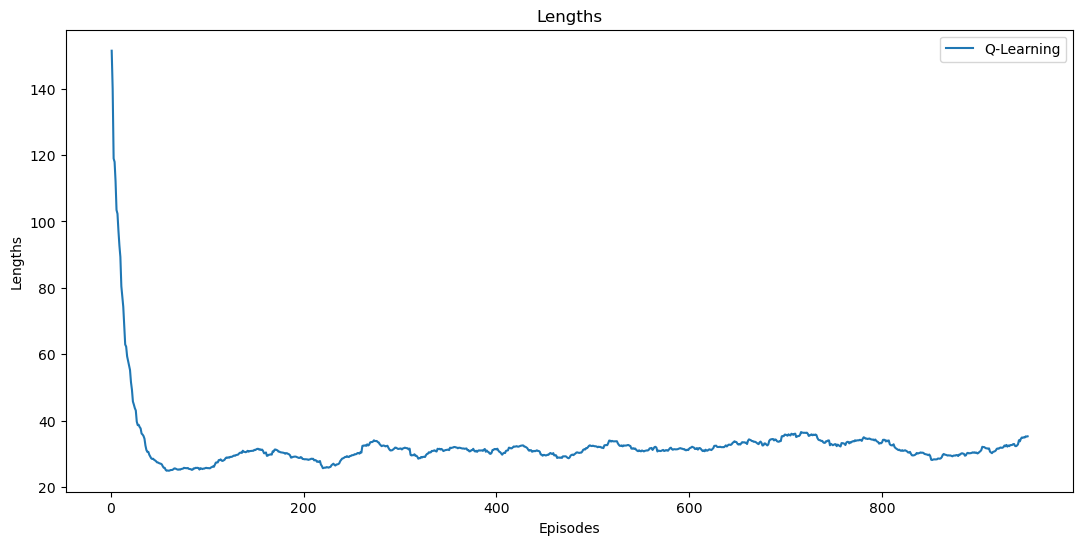

In [6]:
# Learning parameters
episodes = 1000
ep_limit = 50
alpha = .3
gamma = .9
epsilon = .1
temp = 1

rewser = []
lenser = []

litres = np.arange(1, episodes + 1)  # Learning iteration values
window = 50  # Rolling window

t = timer()

# Q-Learning
_, rews, lengths = q_learning(env, episodes, alpha, gamma, softmax, epsilon)

rews = rolling(rews, window)
rewser.append({"x": np.arange(1, len(rews) + 1), "y": rews, "ls": "-", "label": "Q-Learning"})
lengths = rolling(lengths, window)
lenser.append({"x": np.arange(1, len(lengths) + 1), "y": lengths, "ls": "-", "label": "Q-Learning"})

print("Execution time: {0}s".format(round(timer() - t, 4)))

# Rewards
plot(rewser, "Rewards", "Episodes", "Rewards")
# Lunghezze
plot(lenser, "Lengths", "Episodes", "Lengths")

## Solution

In [7]:
t = timer()

solution = my_solution(env)
print(f"Execution time: {round(timer() - t, 4)}s\n") 
solution_render = np.vectorize(env.actions.get)(solution.reshape(env.shape))
print(solution_render)

Execution time: 2.1688s

[['R' 'D' 'L' 'L' 'L' 'L' 'D' 'L' 'L']
 ['L' 'R' 'R' 'R' 'R' 'R' 'D' 'L' 'L']
 ['L' 'U' 'L' 'L' 'L' 'L' 'D' 'L' 'L']
 ['R' 'R' 'R' 'D' 'R' 'R' 'D' 'L' 'L']
 ['L' 'L' 'L' 'D' 'L' 'L' 'R' 'D' 'L']
 ['L' 'U' 'R' 'D' 'L' 'L' 'L' 'D' 'L']
 ['L' 'D' 'L' 'R' 'D' 'L' 'R' 'D' 'L']
 ['L' 'D' 'L' 'L' 'D' 'L' 'L' 'D' 'L']
 ['R' 'R' 'R' 'R' 'R' 'R' 'L' 'L' 'U']]


<img src="images/road_env.jpg" style="zoom: 26%;"/>

Using the **Q-Learning** algorithm with the **softmax** exploration function, we noticed that by using a high number of episodes we get a more stable computation, both in terms of rewards and length, than what we got with **epsilon-greedy**. This said, the solution given by the latter seems statistically more optimal, only crossing one double traffic light and 6 single ones, although the length of the path itself is usually slightly longer
<br>


**epsilon_greedy PLOTS**

- overall best solution
- less stable computation and less consistent solutions
- faster execution *(~9 seconds for 10'000 episodes)*

<img src="images/epsilon-greedy-rewards.png" style="zoom: 50%;"/> <img src="images/epsilon-greedy-lenghts.png" style="zoom: 50%;"/>

**softmax PLOTS**

- correct result, although apparently slightly less optimal
- more stable results and computation
- slower in execution *(~13 secondi per 10'000 episodi)*

<img src="images/softmax-rewards.png" style="zoom: 50%;"/> <img src="images/softmax-length.png" style="zoom: 50%;"/>